In [1]:
from pivot_points import plot_data
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# import plotly.express as px
# import numpy as np


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                      Datetime        Open        High         Low  \
0    2023-01-23 00:00:00+00:00  140.563004  140.914001  140.460007   
1    2023-01-23 01:00:00+00:00  140.718002  140.845001  140.557999   
2    2023-01-23 02:00:00+00:00  140.759995  140.807999  140.649994   
3    2023-01-23 03:00:00+00:00  140.705994  140.951004  140.628998   
4    2023-01-23 04:00:00+00:00  140.919998  141.298004  140.908997   
...                        ...         ...         ...         ...   
3444 2023-08-11 18:00:00+01:00  158.643997  158.744995  158.597000   
3445 2023-08-11 19:00:00+01:00  158.686996  158.746002  158.641998   
3446 2023-08-11 20:00:00+01:00  158.735001  158.746002  158.639008   
3447 2023-08-11 21:00:00+01:00  158.662994  158.705002  158.584000   
3448 2023-08-11 22:00:00+01:00  158.595993  158.669998  158.595993   

           Close     

In [2]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)


Atkreipkite dėmesį, kad šis projektas nesuteikia asmeninės investavimo patarimų, ir aš nesu kvalifikuotas licencijuotas investavimo patarėjas. Visi čia rasti duomenys skirti tik pramogai arba švietimo projektų tikslams ir neturėtų būti traktuojami kaip asmeniniai investavimo, prekevimo patarimai.

1. Importuojam reikalingas bibliotekas
2. Atsisiunciam duonbaze is https://www.cftc.gov/ EUR/JPY (Euro ir Japonijos jeno) kripties nustatymui.
3. Pivot point indikatoriaus konfiguracija, sukurimas
4. Sukuriu pirkimo strategija potencialem pelnui nustatyti
5. Rezultatu perziura
6. Idejos tolesniam developinimui
 
 

"Paleidus `cotEURJPY.ipynb`, ir patikrinus COT duomenis esančius faile pagal gautus duomenis priimame sprendimą, jog mūsų algoritmas tik pirks EURJPY. Tada užkrauname duomenų bazę `plot_data`, kuri bus naudojama tolesniam projekto vystymui.



Apačioje pateikiu mūsų algoritmo pavyzdį „ideal scenario“.
Perkame, kai kaina yra virš 'pivot point', o pirmas pelno išėmimas yra ties 'resistance1', antras - ties 'resistance2'.

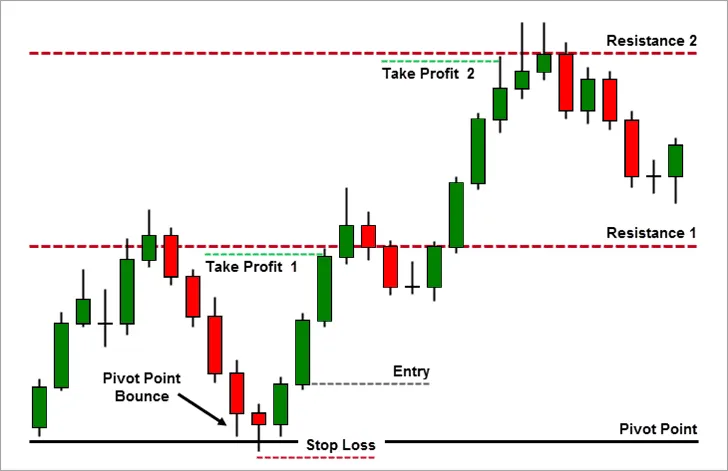

In [3]:
from PIL import Image as PILImage
from IPython.display import display

webp_image_path = '/Users/lokys/Visual Code/Projektas_FX/pivots.webp'

# Uzkrauna ir konvertuoja  WebP nuotrauka i PNG
img = PILImage.open(webp_image_path)
png_image_path = '/Users/lokys/Visual Code/Projektas_FX/pivots.png'
img.save(png_image_path, 'PNG')

display(PILImage.open(png_image_path))



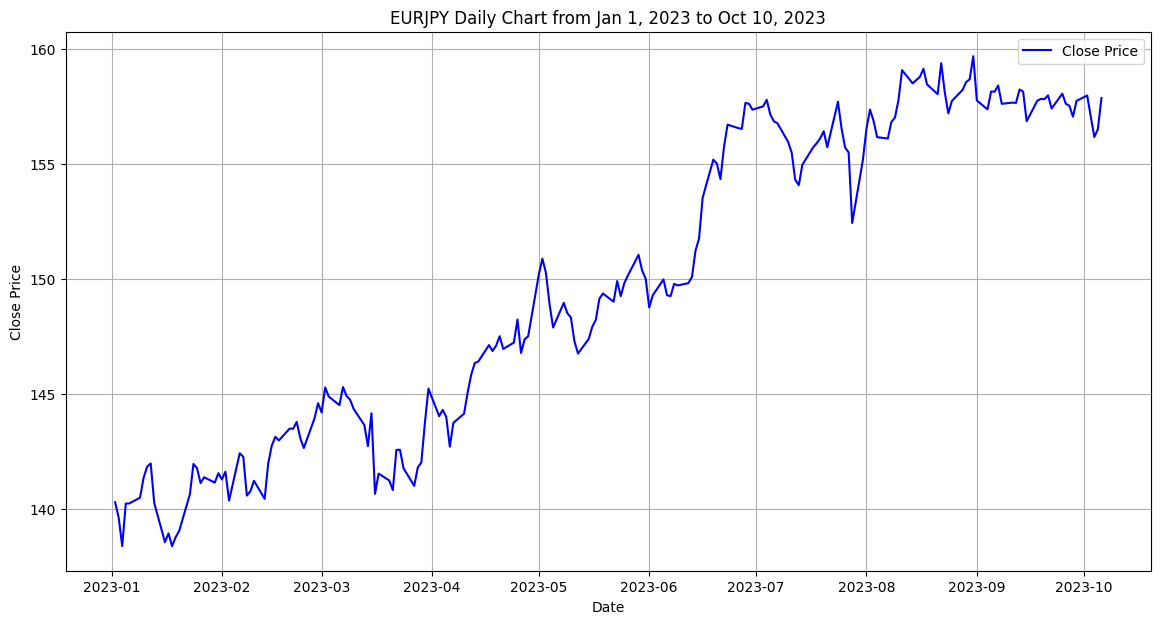

In [4]:


# Download data
data = yf.download("EURJPY=X", start="2023-01-01", end="2023-10-11", progress=False)

# Ensure that data contains values, as there can sometimes be issues with Yahoo Finance
if not data.empty:
    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.title('EURJPY Daily Chart from Jan 1, 2023 to Oct 10, 2023')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available for the given date range.")



Aš naudoju 1:10 svertą su 1000 USD sąskaitoje, nes tai leidžia man padidinti potencialų pelną, neperkraunant sąskaitos ir išlaikant saugų maržos 
rezervą. Tačiau reikėtų nepamiršti, kad svertas didina tiek potencialų pelną, tiek ir potencialius nuostolius.

In [5]:


def pivot_point_strategy(plot_data, initial_equity=1000, pip_value=10, lots=0.1):
    
    data = pd.DataFrame(plot_data)
    data['Signal'] = ''
    data['Position'] = 0
    data['Equity'] = initial_equity

    
    position = 0
    equity = initial_equity
    pips = 0
    stats = []
    trade_counter = 0  
    prev_pp = None  

    
    for i in range(len(data)):
        date = data['Datetime'].iloc[i]
        close = data['Close'].iloc[i]
        pp = data['PP'].iloc[i]
        r1 = data['R1'].iloc[i]
        r2 = data['R2'].iloc[i]

        if prev_pp != pp:
            trade_counter = 0
            prev_pp = pp

        if trade_counter < 3:
            if position == 0 and close > pp:
                data.at[i, 'Signal'] = 'Buy'
                position = 1
                trade_counter += 1
                entry_price = close
                stats.append((date, equity))
            elif position == 1 and close > r1:
                data.at[i, 'Signal'] = 'Sell Half at R1'
                pips = (close - entry_price) * 100
                equity += pips * pip_value * lots * 0.5
                position = 0.5
                trade_counter += 1
                stats.append((date, equity))
            elif position == 0.5 and close > r2:
                data.at[i, 'Signal'] = 'Sell Remaining at R2'
                pips = (close - entry_price) * 100
                equity += pips * pip_value * lots * 0.5
                position = 0
                trade_counter += 1
                stats.append((date, equity))
            elif position != 0 and close < pp:
                data.at[i, 'Signal'] = 'Sell All (Below PP)'
                pips = (close - entry_price) * 100
                equity += pips * pip_value * lots
                position = 0
                trade_counter += 1
                stats.append((date, equity))

        data.at[i, 'Position'] = position
        data.at[i, 'Equity'] = equity

    return data, stats











In [6]:
print(plot_data.columns)


Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'PP', 'S1', 'S2', 'R1',
       'R2'],
      dtype='object')


In [7]:


initial_equity = 1000
# isikvieciu funkcija
data, stats = pivot_point_strategy(plot_data, initial_equity=initial_equity)

# parodau statistika
print("Date, Equity Value for Each Trade")
print("-" * 40)
for date, equity_value in stats:
    print(f"{date}, ${equity_value:.2f}")

print(f"\nInitial Equity: ${initial_equity}")

# The final equity is the equity value of the last trade
print(f"Final Equity: ${stats[-1][1]:.2f}" if stats else f"Final Equity: ${initial_equity}")


Date, Equity Value for Each Trade
----------------------------------------
2023-01-23 00:00:00+00:00, $1000.00
2023-01-30 03:00:00+00:00, $1047.60
2023-01-30 08:00:00+00:00, $1047.60
2023-01-31 01:00:00+00:00, $1016.90
2023-02-06 00:00:00+00:00, $1016.90
2023-02-07 08:00:00+00:00, $881.00
2023-02-07 11:00:00+00:00, $881.00
2023-02-13 00:00:00+00:00, $788.60
2023-02-13 05:00:00+00:00, $788.60
2023-02-14 14:00:00+00:00, $872.95
2023-02-23 18:00:00+00:00, $1029.45
2023-02-23 19:00:00+00:00, $1029.45
2023-02-24 00:00:00+00:00, $1012.55
2023-02-27 00:00:00+00:00, $1012.55
2023-02-27 05:00:00+00:00, $1000.45
2023-02-27 08:00:00+00:00, $1000.45
2023-03-06 00:00:00+00:00, $1056.15
2023-03-06 08:00:00+00:00, $1056.15
2023-03-06 10:00:00+00:00, $1051.55
2023-03-15 00:00:00+00:00, $1051.55
2023-03-15 01:00:00+00:00, $1043.65
2023-03-15 02:00:00+00:00, $1043.65
2023-03-20 00:00:00+00:00, $778.05
2023-03-21 10:00:00+00:00, $778.05
2023-03-21 14:00:00+00:00, $752.15
2023-03-27 07:00:00+01:00, $752.1

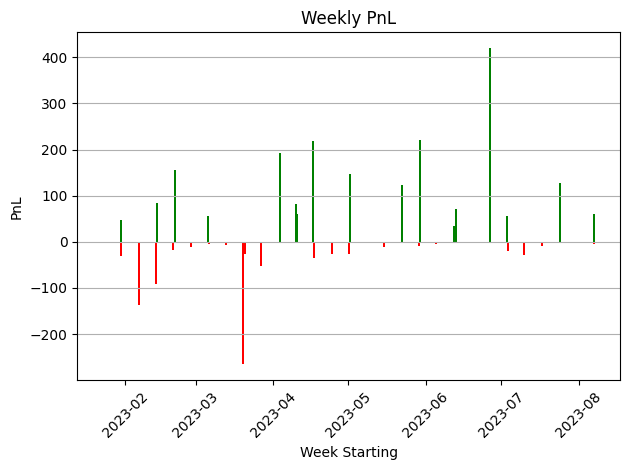

In [8]:
import matplotlib.pyplot as plt

# istraukiu datas, equities is stats listo
dates = [item[0] for item in stats]
equities = [item[1] for item in stats]
daily_pnl = [equities[0] - initial_equity] + [equities[i] - equities[i-1] for i in range(1, len(equities))]

# Funkcija istraukti data naujos savaites
def get_week_start(date):
    return date - pd.Timedelta(days=date.weekday())

# sugrupuoju savaitinius PnL duomenis
weekly_pnl = {}
for i, date in enumerate(dates):
    week_start = get_week_start(date)
    if week_start not in weekly_pnl:
        weekly_pnl[week_start] = 0
    weekly_pnl[week_start] += daily_pnl[i]

# istraukiu data 
weeks = list(weekly_pnl.keys())
weekly_pnl = list(weekly_pnl.values())


plt.bar(weeks, weekly_pnl, color=['g' if pnl >= 0 else 'r' for pnl in weekly_pnl])
plt.title('Weekly PnL')
plt.xlabel('Week Starting')
plt.ylabel('PnL')
plt.xticks(rotation=45)
plt.grid(axis='y')


plt.tight_layout()
plt.show()



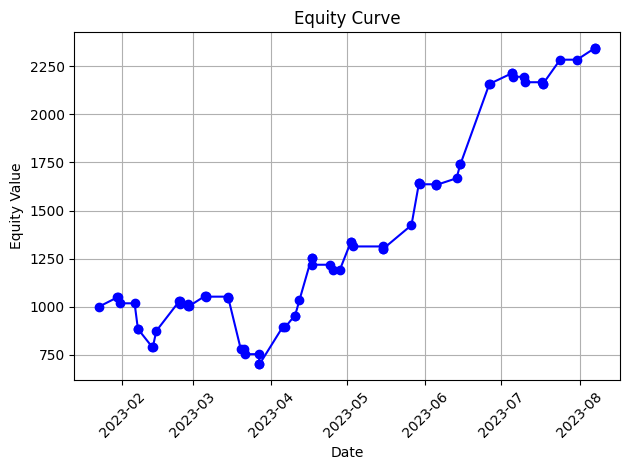

In [9]:
import matplotlib.pyplot as plt

# istraukiu dates and equities from the stats list
dates = [item[0] for item in stats]
equities = [item[1] for item in stats]


plt.plot(dates, equities, marker='o', linestyle='-', color='b')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.xticks(rotation=45)
plt.grid(True)


plt.tight_layout()
plt.show()


In [10]:
# suskaiciuoja PnL after kiekvieno trade
pnl_per_trade = [equities[0] - initial_equity] + [equities[i] - equities[i-1] for i in range(1, len(equities))]

# suskaiciuoja statistika 
total_trades = len(pnl_per_trade)
profit_trades = len([pnl for pnl in pnl_per_trade if pnl > 0])
loss_trades = len([pnl for pnl in pnl_per_trade if pnl < 0])
break_even_trades = total_trades - profit_trades - loss_trades

max_profit = max(pnl_per_trade)
max_loss = min(pnl_per_trade)
avg_profit = sum(pnl for pnl in pnl_per_trade if pnl > 0) / profit_trades if profit_trades != 0 else 0
avg_loss = sum(pnl for pnl in pnl_per_trade if pnl < 0) / loss_trades if loss_trades != 0 else 0


print("Total Trades:", total_trades)
print("Profit Trades:", profit_trades)
print("Loss Trades:", loss_trades)
print("Break-even Trades:", break_even_trades)
print("Max Profit:", max_profit)
print("Max Loss:", max_loss)
print("Average Profit:", avg_profit)
print("Average Loss:", avg_loss)



Total Trades: 70
Profit Trades: 17
Loss Trades: 20
Break-even Trades: 33
Max Profit: 419.7998046875
Max Loss: -265.6005859375
Average Profit: 127.05585255342372
Average Loss: -40.99510192871094


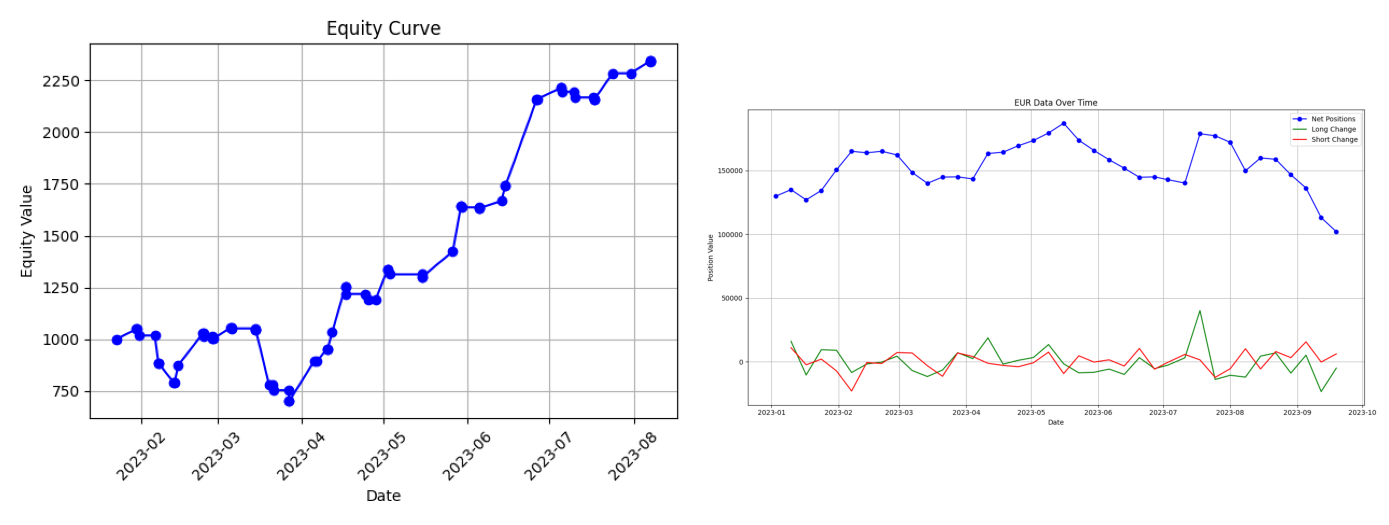

In [11]:
#pip3 install opencv-python 
import cv2
from matplotlib import pyplot as plt

image1 = cv2.imread('/Users/lokys/Visual Code/Projektas_FX/images/Equity.png')
image2 = cv2.imread('/Users/lokys/Visual Code/Projektas_FX/images/cot_eur.png')

# konvertuoju is BGR i RGB
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# pateikiam images vienas salia kito
fig, axarr = plt.subplots(1, 2, figsize=(14, 14))

axarr[0].imshow(image1_rgb)
axarr[0].axis('off') 

axarr[1].imshow(image2_rgb)
axarr[1].axis('off')  

plt.tight_layout()
plt.show()



**EURJPY Backtestavimo Santrauka (2023 m. sausio 23 d. - rugpjūčio 7 d.):**
- **Trukmė**: Maždaug 6 mėnesiai.
- **Pradinis Kapitalas**: $1,000.
- **Galutinis Kapitalas**: $2,340.05.
- **Grynasis Pelnas**: $1,340.05.
- **Procentinė Grąža**: 134%.
- **Didžiausias Nuosmukis**: Maždaug 33,8% (nuo aukščiausios $1,056.15 vertės iki žemiausios $699.15 vertės).

Pastaba: Strategija buvo išbandyta šešių mėnesių laikotarpiu ir parodė viliojantį 134% grąžos rodiklį. Tačiau buvo pastebėti reikšmingi nuosmukiai. Norint tobulinti strategiją, reikia įtraukti papildomus filtrus. COT („Commitment of Traders“) duomenų įtakos analizė gali suteikti vertingų įžvalgų, todėl ją reikėtų apsvarstyti įtraukiant į strategiją. Be to, rekomenduojama testavimas įvairiose rinkos sąlygose, pvz., šoninėje ir mažėjančioje rinkoje, galbut padidinti testavimo laikotarpi iki 36men. Žinant, kad EURJPY turi vieną iš aiškiausių tendencijų, verta atlikti ir kitų valiutų backtestavimą.


